# Detecting COVID-19 in X-ray(VGG-16)

### Import Libraries

In [1]:
import os
import cv2
import numpy as np
import argparse
import matplotlib.pyplot as plt

from imutils import paths
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Preprocess Data

In [2]:
# list of images in datasets
image_paths = list(paths.list_images(r"C:\Users\SRKT\Desktop\Covid_xray"))

data= []
labels = []

for image_path in image_paths:
    
    # extract the class name from file name
    label = image_path.split(os.path.sep)[-2]
    
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(224,224))
    
    # load image, swap channels and resize it
    #image=load_img(image_path,target_size=(224,224)) #load image
    #image=img_to_array(image) # add channel
    #image=np.expand_dims(image,axis=0) # add the number of image
    #image=preprocess_input(image) # subtracts the mean RGB channles of imagenet datset.
    
    # update the data and labels
    data.append(image)
    labels.append(label)
    
# convert the data to numpy array while scaling pixel range from [0,1]
data=np.array(data,dtype="float32")/255.0
labels=np.array(labels)

In [3]:
# perform one-hot encoding on the labels
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels = to_categorical(labels) # onehot vector

#### Spliting Data into Train_Test

In [4]:
(x_train,x_test,y_train,y_test)=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=42)
# stratify split in same way as labels has %of 0 and %1

# initialize the training dat augmentation
train_aug=ImageDataGenerator(rotation_range=15,
                             fill_mode="nearest" )

### Model Bulding

In [5]:
# load Resnet network ,ensuring the head FC layer sets are left off
base_model=VGG16(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

# construct head of the model it will placed on top of base model
head_model=base_model.output
head_model=AveragePooling2D(pool_size=(4,4))(head_model)
head_model=Flatten()(head_model)
head_model=Dense(128,activation="relu")(head_model)
head_model=Dropout(0.5)(head_model)
head_model=Dense(2,activation="softmax")(head_model)

In [6]:
# place head model in top of base model , which final model which we will train
model=Model(inputs=base_model.input,outputs=head_model)

# loop over all the layers in the base model and freeze them so that they will not update in training
for layer in base_model.layers:
    layer.trainable=False

### Train the Model

In [7]:
opt=Adam(lr=1e-3,decay=1e-3/64)

# compile the model
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

# train the head of the model
H=model.fit(
    train_aug.flow(x_train,y_train,batch_size=64),
    steps_per_epoch=len(x_train)//64,
    validation_data=(x_test,y_test),
    validation_steps=len(x_test)//64,
    epochs=20)

Epoch 1/50
62/62 [==============================] - 37s 599ms/step - loss: 0.6756 - accuracy: 0.5811 - val_loss: 0.6076 - val_accuracy: 0.6439
Epoch 2/50
62/62 [==============================] - 34s 543ms/step - loss: 0.6020 - accuracy: 0.6704 - val_loss: 0.5855 - val_accuracy: 0.6398
Epoch 3/50
62/62 [==============================] - 37s 605ms/step - loss: 0.5772 - accuracy: 0.6850 - val_loss: 0.5520 - val_accuracy: 0.6922
Epoch 4/50
62/62 [==============================] - 39s 635ms/step - loss: 0.5606 - accuracy: 0.7056 - val_loss: 0.4983 - val_accuracy: 0.7746
Epoch 5/50
62/62 [==============================] - 39s 625ms/step - loss: 0.5353 - accuracy: 0.7167 - val_loss: 0.4835 - val_accuracy: 0.7847
Epoch 6/50
62/62 [==============================] - 41s 654ms/step - loss: 0.5115 - accuracy: 0.7485 - val_loss: 0.5241 - val_accuracy: 0.7223
Epoch 7/50
62/62 [==============================] - 40s 643ms/step - loss: 0.5082 - accuracy: 0.7470 - val_loss: 0.4551 - val_accuracy: 0.7847

### plot accuracy vs loss graph

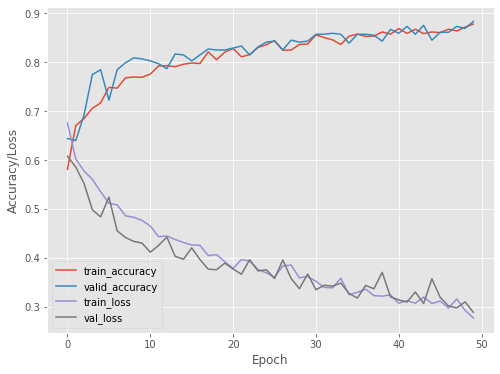

In [10]:
plt.figure(figsize=(8,6))
plt.style.use("ggplot")
N=50
plt.plot(np.arange(0,N), H.history["accuracy"],label="train_accuracy")
plt.plot(np.arange(0,N),H.history["val_accuracy"],label="valid_accuracy")
plt.plot(np.arange(0,N),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,N),H.history["val_loss"],label="val_loss")

plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend()

#### Save the Model

In [12]:
# saves weights of model
model.save_weights(r"C:\Users\SRKT\Desktop\Covid_xray\xray_model.h5")

# save the model to json
model_json=model.to_json()
with open(r"C:\Users\SRKT\Desktop\Covid_xray\xray.json","w") as json_file:
    json_file.write(model_json)

In [14]:
model.save(r"C:\Users\SRKT\Desktop\Covid_xray\model.h5")